Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing Data Percentage for each column:
PoolQC           99.520548
MiscFeature      96.301370
Alley            93.767123
Fence            80.753425
MasVnrType       59.726027
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
Length: 81, dtype: float64


<ipython-input-33-44fc66b291f1>:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traincsv[column] = traincsv.groupby("Neighborhood")[column].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.ffill()))
<ipython-input-33-44fc66b291f1>:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  traincsv[column] = traincsv.groupby("Neighborhood")[column].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.ffill()))
<ipython-input-33-44fc66b291f1>:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is dep

Engineered features added: HouseAge, RemodAge, TotalSF
Dropping the lowest three correlating original features: ['YrSold', '2ndFlrSF', 'YearRemodAdd', 'YearBuilt']


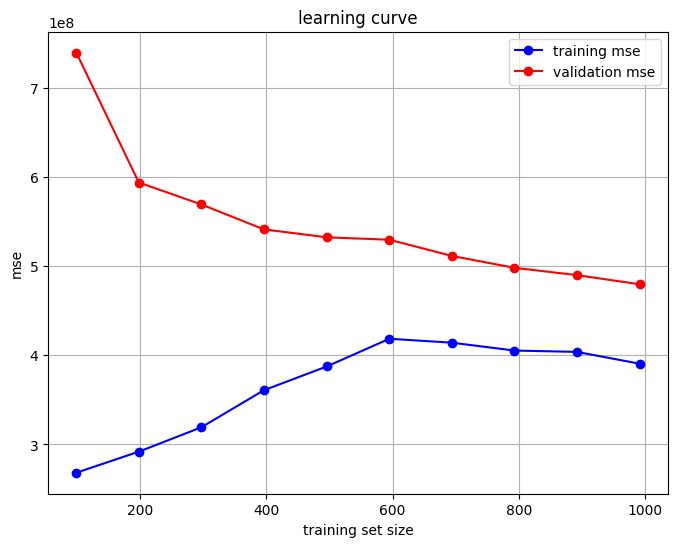

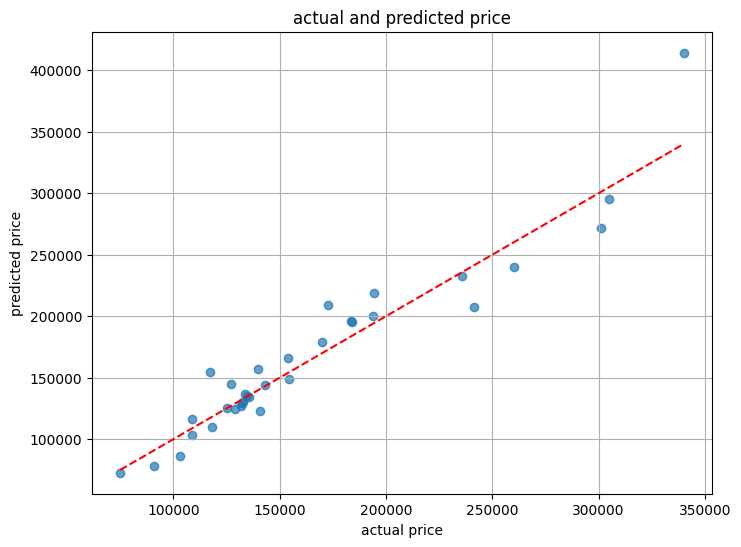


overfitting and underfitting testing:
training RMSE: 19922.13
validation RMSE: 19467.94
training R2: 0.91
validation R2: 0.93
the model is balanced

Model: Ridge Regression
RMSE: 20181.9845
MAE: 13649.8550
Accuracy: 0.8977
train: 0.9104
Best model and scaler saved successfully.


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import learning_curve
import joblib
from google.colab import drive
drive.mount('/content/drive')

traincsv= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Task 1/train.csv")

traincsv.duplicated().sum()
traincsv.isnull().sum()

#data missing percentage
missing_percentages = traincsv.isnull().mean() * 100
print("Missing Data Percentage for each column:")
print(missing_percentages.sort_values(ascending=False))

# columns with high missing values
columnsWithHighMissingValues = traincsv.columns[traincsv.isnull().any()]
columnsWithHighMissingValues

traincsv.drop(columns=['Id', 'LotArea'], inplace=True)
numericalColumns = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
categoricalColumns = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                      'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
                      'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                      'PoolQC', 'Fence', 'MiscFeature']

for column in numericalColumns:
    traincsv[column] = traincsv.groupby("Neighborhood")[column].transform(lambda x: x.fillna(x.median()))

for column in categoricalColumns:
    traincsv[column] = traincsv.groupby("Neighborhood")[column].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.ffill()))

columnsWithHighMissingValues = traincsv.columns[traincsv.isnull().any()]

traincsv.isnull().sum()

dropColumns = [col for col in traincsv.columns if traincsv[col].nunique() == 1]
traincsv = traincsv.drop(columns=dropColumns)

# remove outliers
numerical_Columns = traincsv.select_dtypes(include=["number"]).columns
for column in numerical_Columns:
    quartile1 = traincsv[column].quantile(0.25)
    quartile3 = traincsv[column].quantile(0.75)
    interquartile = quartile3 - quartile1
    lowerBound = quartile1 - 1.5 * interquartile
    upperBound = quartile3 + 1.5 * interquartile
    traincsv[column] = np.clip(traincsv[column], lowerBound, upperBound)

if all(col in traincsv.columns for col in ['YearBuilt', 'YrSold']):
    traincsv['HouseAge'] = traincsv['YrSold'] - traincsv['YearBuilt']

if all(col in traincsv.columns for col in ['YearRemodAdd', 'YrSold']):
    traincsv['RemodAge'] = traincsv['YrSold'] - traincsv['YearRemodAdd']

if all(col in traincsv.columns for col in ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']):
    traincsv['TotalSF'] = traincsv['1stFlrSF'] + traincsv['2ndFlrSF'] + traincsv['TotalBsmtSF']

print("Engineered features added: HouseAge, RemodAge, TotalSF")

#drop the lowest four features used in the new features to match same number of features
orig_features = ['YearBuilt', 'YrSold', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']
orig_features = [col for col in orig_features if col in traincsv.columns]

if orig_features:
    corr_values = traincsv[orig_features + ['SalePrice']].corr()['SalePrice'].abs()
    corr_values = corr_values.drop('SalePrice', errors='ignore')

    lowest_three = corr_values.nsmallest(4).index.tolist()
    print("Dropping the lowest three correlating original features:", lowest_three)

    traincsv.drop(columns=lowest_three, inplace=True)
else:
    print("No original features found to evaluate for dropping.")


traincsv = pd.get_dummies(traincsv, drop_first=True)

correlatingFeatures = traincsv.corr()["SalePrice"].abs().sort_values(ascending=False)
TopFeatures = correlatingFeatures[correlatingFeatures > 0.1].index.drop("SalePrice")
X = traincsv[TopFeatures]
y = traincsv["SalePrice"]

x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.15, random_state=42)

# feature scaling using standardscaler
standardscaler = StandardScaler()
x_train = standardscaler.fit_transform(x_train)
x_val = standardscaler.transform(x_val)
x_test = standardscaler.transform(x_test)

models = {
    "Ridge Regression": Ridge()
}

# hypertuning
ridgeParameters = {"alpha": [0.1, 1, 10, 100]}

ridgeGrid = GridSearchCV(Ridge(), ridgeParameters, cv=5, scoring='r2')

ridgeGrid.fit(x_train, y_train)

models["Ridge Regression"] = ridgeGrid.best_estimator_

# evaluation
results = {}
for name, model in models.items():
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)

  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  train1 = model.score(x_train,y_train)

  r2 = r2_score(y_test, y_pred)

  results[name] = {"RMSE": rmse, "MAE": mae, "Accuracy": r2 , "train": train1 }

# learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model, x_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mse = -np.mean(train_scores, axis=1)
val_mse = -np.mean(val_scores, axis=1)

#plot for loss function mse
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mse, 'o-', color='blue', label='training mse')
plt.plot(train_sizes, val_mse, 'o-', color='red', label='validation mse')
plt.xlabel('training set size')
plt.ylabel('mse')
plt.title('learning curve')
plt.legend()
plt.grid(True)
plt.show()
#plot for actual and pridiction of the sale price
y_test_pred = best_model.predict(x_test)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.xlabel("actual price")
plt.ylabel("predicted price")
plt.title("actual and predicted price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.show()

# overfitting and underfitting test so we can know if its gonna predict new data with high accuracy
best_model = models["Ridge Regression"]

y_train_pred = best_model.predict(x_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

y_val_pred = best_model.predict(x_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print("\noverfitting and underfitting testing:")
print("training RMSE: {:.2f}".format(train_rmse))
print("validation RMSE: {:.2f}".format(val_rmse))
print("training R2: {:.2f}".format(train_r2))
print("validation R2: {:.2f}".format(val_r2))

if val_rmse > train_rmse * 1.2:
    print("the model is overfitting")
elif train_rmse > val_rmse * 1.2:
    print("the model is underfitting")
else:
    print("the model is balanced")

for name, metrics in results.items():
    print(f"\nModel: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


# save the best model and the scaler to drive
joblib.dump(best_model, "/content/drive/MyDrive/Colab Notebooks/Task 1/best_model.pkl")
joblib.dump(standardscaler, "/content/drive/MyDrive/Colab Notebooks/Task 1/standardscaler.pkl")
print("Best model and scaler saved successfully.")

#pridiction function to test new data
def preprocess_and_predict(new_data):

    scaler = joblib.load("/content/drive/MyDrive/Colab Notebooks/Task 1/standardscaler.pkl")

    new_data_processed = new_data[TopFeatures]

    new_data_scaled = scaler.transform(new_data_processed)

    model = joblib.load("/content/drive/MyDrive/Colab Notebooks/Task 1/best_model.pkl")

    predictions = model.predict(new_data_scaled)
    return predictions

# new_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Task 1/new_test_data.csv")
# preds = preprocess_and_predict(new_data)
# print(preds)

